In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler

In [3]:
# variables
rnd = 42
points_to_show = 100

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df.set_index('Id', inplace=True)

In [6]:
# get cat features
cat_feat = df.dtypes[df.dtypes == object].index
# fill cat feat with nans
df[cat_feat] = df[cat_feat].fillna('nan')
# get num features without target value
num_feat = [f for f in df if f not in cat_feat and f not in ['SalePrice']]

In [7]:
# scaling
scaler = StandardScaler()
df[num_feat] = scaler.fit_transform(df[num_feat])
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['SalePrice']), df['SalePrice'], test_size=0.2, random_state=rnd)

In [8]:
# dummies
train_dummies = pd.get_dummies(X_train[cat_feat], columns=cat_feat)
test_dummies = pd.get_dummies(X_test[cat_feat], columns=cat_feat)

dummy_cols = list(set(train_dummies) & set(test_dummies))

dummy_train = train_dummies[dummy_cols]
dummy_test = test_dummies[dummy_cols]

X_train = pd.concat([X_train[num_feat].fillna(-999),
                     dummy_train], axis=1)

X_test = pd.concat([X_test[num_feat].fillna(-999),
                     dummy_test], axis=1)

## Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split


In [10]:
rf = RandomForestRegressor(n_estimators=20, max_depth=5)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [11]:
# predictions
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
print('Test score of random forest: {:.3f}'.format(rf.score(X_test, y_test)))

Test score of random forest: 0.859


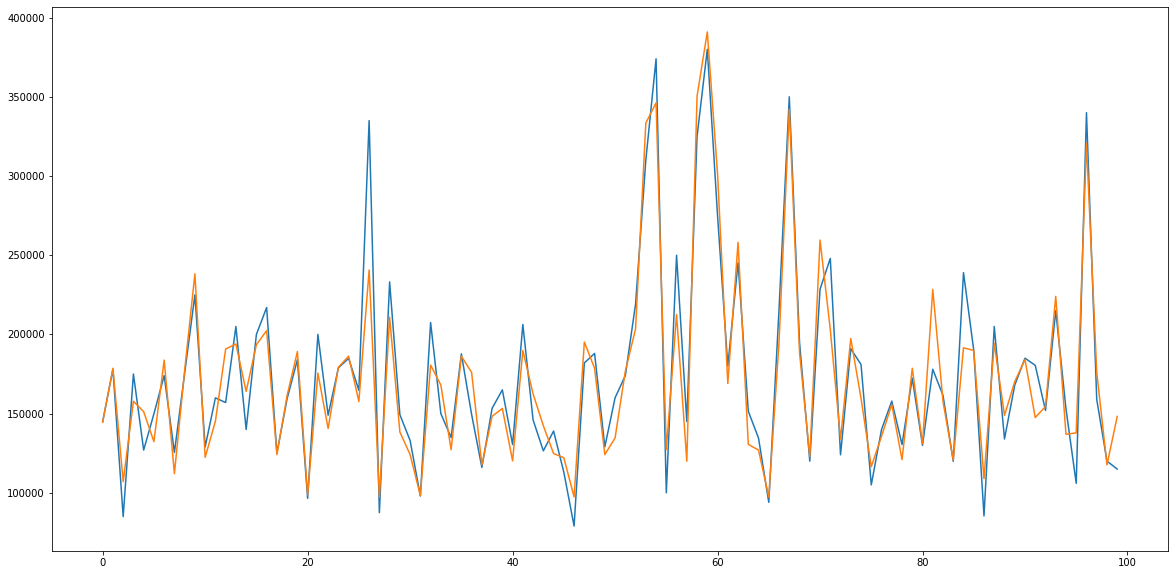

In [14]:
plt.figure(figsize=(20,10))
plt.plot(y_train[:points_to_show].to_list())
plt.plot(train_pred[:points_to_show])
plt.show()

Most important features:
OverallQual	0.624
GrLivArea	0.132
TotalBsmtSF	0.038
2ndFlrSF	0.031
BsmtFinSF1	0.024
1stFlrSF	0.017
GarageCars	0.016
FullBath	0.015
LotArea	0.014
YearBuilt	0.013
BsmtQual_Ex	0.007
GarageArea	0.007


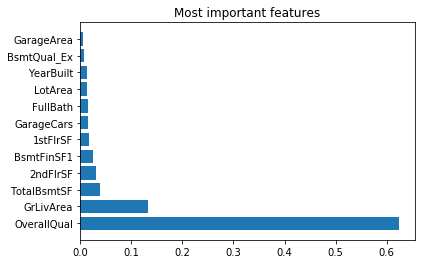

In [15]:
importances = rf.feature_importances_
feature_names = X_train.columns

most_important = {feature_names[i]: imp for i, imp in enumerate(importances) if imp > 0.005}
most_important = {k: v for k, v in sorted(most_important.items(), key=lambda item: -item[1])}
print("Most important features:") 
print('\n'.join('{}\t{:.3f}'.format(k,v) for k, v in most_important.items()))

fig, ax = plt.subplots()
y_pos = np.arange(len(most_important))
ax.barh(y_pos, most_important.values())
ax.set_yticks(y_pos)
ax.set_yticklabels(most_important.keys())
ax.set_title('Most important features')
plt.show()

## Stacking

In [58]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor

In [64]:
estimators = [
    ('linear', LinearRegression()),
    ('sgd', SGDRegressor(eta0=0.000001, max_iter=10000)),
    ('tree', DecisionTreeRegressor())
]

In [65]:
for name, est in estimators:
    est.fit(X_train, y_train)
    print('Test score of {} estimator: {:.3f}'.format(name, est.score(X_test, y_test)))

Test score of linear estimator: 0.837
Test score of sgd estimator: 0.395
Test score of tree estimator: 0.790


In [66]:
# cv=10 enables 10-fold cross-validation
reg = StackingRegressor(estimators, final_estimator=RandomForestRegressor(), cv=10)

In [67]:
reg.fit(X_train, y_train)
print('Test score of stacking regressor: {:.3f}'.format(reg.score(X_test, y_test)))

Test score of stacking regressor: 0.856


In [69]:
train_pred = reg.predict(X_train)
test_pred = reg.predict(X_test)

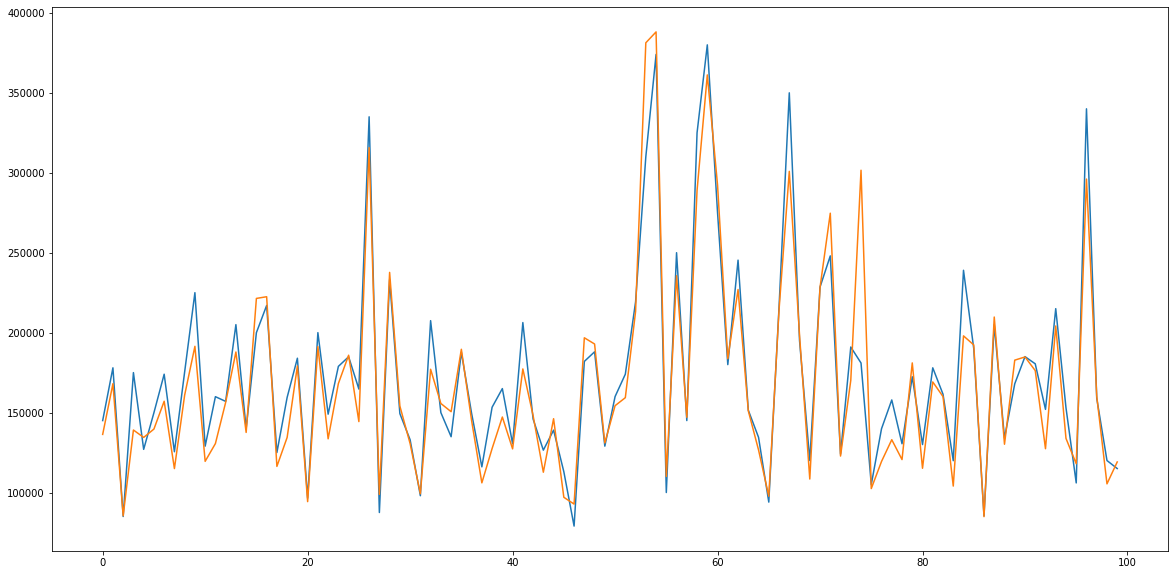

In [70]:
plt.figure(figsize=(20,10))
plt.plot(y_train[:points_to_show].to_list())
plt.plot(train_pred[:points_to_show])
plt.show()

## Results
Test score of RandomForest: 0.859  
Test score of linear estimator: 0.837  
Test score of sgd estimator: 0.395  
Test score of tree estimator: 0.790

Stacking regressor: 0.856